In [1]:
import pandas as pd 
import numpy as np

In [45]:
def translate_df(df, translation, columns_to_translate):
    
    df = df.copy()
    translation_table = str.maketrans(translation)
    for column in columns_to_translate:
        df['translation_'+column] = df[column].apply(lambda x: x.translate(translation_table))
    return df

In [48]:
#DATA_PATH = '/home/jhenderson/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/'
DATA_PATH = '/Users/james/Documents/Projects/data_sets/tcr_sequences/CI_CRUK_datathon/'

best_translation = pd.read_csv(DATA_PATH + "/reduction_outputs/alphabet.csv", index_col='Unnamed: 0').loc['Letter'].astype(str).to_dict()

## Training data and olga

In [50]:
train = pd.read_csv(DATA_PATH + 'processed_data/train_fixed_lengths.csv')
train = train.dropna(subset=['CDR3B', 'epitope']).reset_index(drop=True)
train['epitope'] = train['epitope'].apply(lambda x: x[2:7])
train['CDR3B'] = train['CDR3B'].apply(lambda x: x[4:14])
train = translate_df(train, best_translation, ['CDR3B', 'epitope'])
train.to_csv(DATA_PATH + "/reduction_outputs/translation_train.csv")

In [53]:
olga = pd.read_csv(DATA_PATH + 'raw_data/olga_preprocessed.csv')
olga['CDR3B_length'] = olga['CDR3B'].apply(lambda x: len(x))
olga = olga[olga['CDR3B_length'] == 15]
olga['CDR3B'] = olga['CDR3B'].apply(lambda x: x[4:14])
olga = translate_df(olga, best_translation, ['CDR3B'])
olga['translation_vector'] = olga['translation_CDR3B'].apply(lambda x: np.array(list(x)).astype(int))
olga_vectors = np.stack(olga['translation_vector'].values)
average_vector = olga_vectors.mean(axis=0)
np.savetxt(DATA_PATH + '/reduction_outputs/average_olga_vector.csv', average_vector, delimiter=',')

## Testing and cancer data

In [59]:
test = pd.read_csv(DATA_PATH + 'processed_data/test_fixed_lengths.csv')
test['epitope'] = test['epitope'].apply(lambda x: x[2:7])
test['CDR3B'] = test['CDR3B'].apply(lambda x: x[4:14])
test = translate_df(test, best_translation, ['CDR3B', 'epitope'])
test.to_csv(DATA_PATH + "/reduction_outputs/translation_test.csv")

In [60]:
cancer = pd.read_csv(DATA_PATH + 'processed_data/cancer_fixed_lengths.csv')
cancer['epitope'] = cancer['epitope'].apply(lambda x: x[2:7])
cancer['CDR3B'] = cancer['CDR3B'].apply(lambda x: x[4:14])
cancer = translate_df(test, best_translation, ['CDR3B', 'epitope'])
cancer.to_csv(DATA_PATH + "/reduction_outputs/translation_cancer.csv")

## Data visualisation  

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

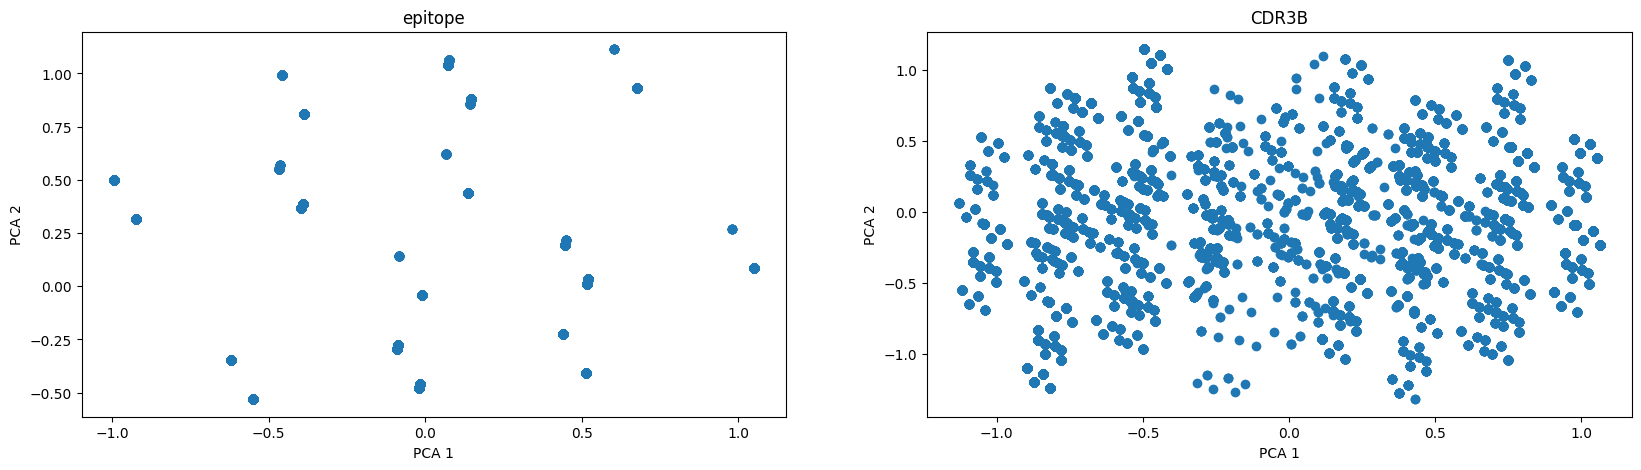

In [66]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

features = ['epitope', 'CDR3B']
for i, feature in enumerate(features):
    X = np.stack(train[f'translation_{feature}'].apply(lambda x: np.array(list(x)).astype(int)).values)
    pca = PCA(n_components=2)
    pca.fit(X) 
    X_r = pca.fit(X).transform(X)
    ax[i].set_title(f"{feature}")
    ax[i].set_xlabel('PCA 1')
    ax[i].set_ylabel('PCA 2')
    ax[i].scatter(X_r[:, 0], X_r[:, 1]);